In [1]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.regularizers import l2

2024-11-15 15:26:48.046268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 15:26:48.056192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 15:26:48.069098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 15:26:48.072832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 15:26:48.083983: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_dir = "archive/train/"
test_dir = "archive/test"
valid_dir ='archive/valid'

Found 0 images in directory: archive/train/
Found 1569 images in directory: archive/train/0
Found 1563 images in directory: archive/train/1


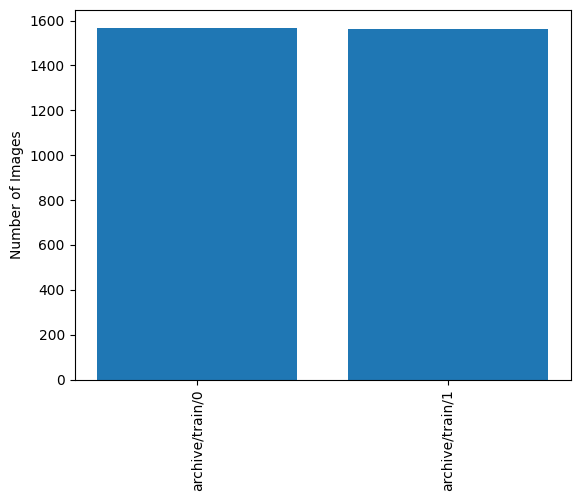

In [3]:
num_images = 0

for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.png')):
            num_images += 1

    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0


subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

In [4]:
"""
minority_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2,
        rotation_range=10,
        brightness_range=(0,10),
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',

)
"""
train_gen =  tf.keras.preprocessing.image.ImageDataGenerator()

"""
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',
)
"""
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [5]:
"""
minority_class_directory = 'archive/train/1'

minority_class_generator = minority_train_gen.flow_from_directory(
    directory=minority_class_directory,
    target_size=(320,320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)

main_generator = main_train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(320, 320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)
"""

"\nminority_class_directory = 'archive/train/1'\n\nminority_class_generator = minority_train_gen.flow_from_directory(\n    directory=minority_class_directory,\n    target_size=(320,320),\n    batch_size=20,\n    class_mode='binary',\n    shuffle=True,\n)\n\nmain_generator = main_train_gen.flow_from_directory(\n    directory=train_dir,\n    target_size=(320, 320),\n    batch_size=20,\n    class_mode='binary',\n    shuffle=True,\n)\n"

In [6]:
train_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(224,224),
        class_mode='binary',
        batch_size=20,
        shuffle=True,
)
val_images = train_gen.flow_from_directory(
        directory=valid_dir,
        target_size=(224,224),
        class_mode='binary',
        shuffle=True,
)
test_images = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(224,224),
        class_mode='binary',
        batch_size=1,
        shuffle=False,
)

Found 3132 images belonging to 2 classes.
Found 818 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [7]:
class_names = os.listdir('archive/train')
print(f"Class names: {class_names}")

Class names: ['0', '1']


In [8]:
images, labels = next(val_images)

print("Shape of images: ", images.shape)
print("Labels", labels.shape)

Shape of images:  (32, 224, 224, 3)
Labels (32,)


Text(0.5, 1.0, '1')

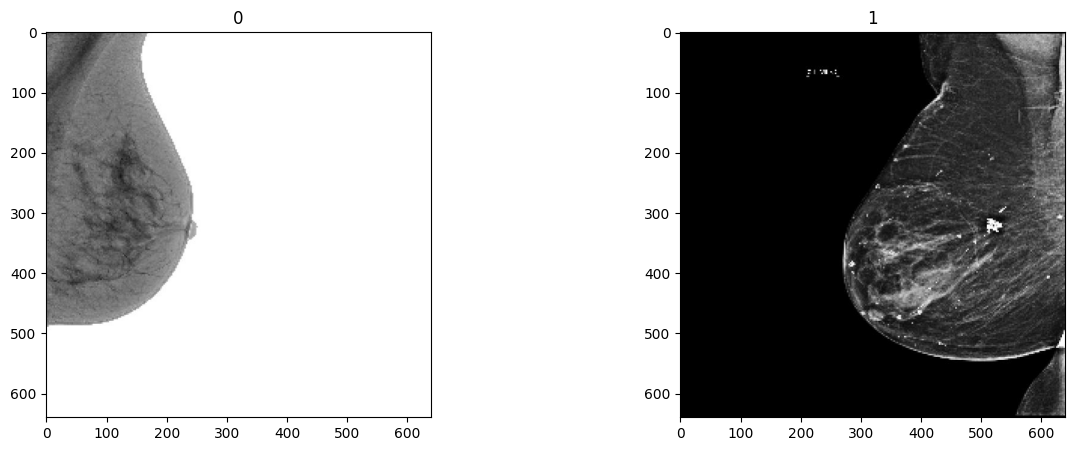

In [9]:
plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 1)
plt.imshow(cv2.imread('archive/train/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg'))
plt.title('0')



plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 2)
plt.imshow(cv2.imread('archive/train/1/10130_1672636630_png.rf.52c6d1c8c6c58c5c1c5fcaaf57feb81d.jpg'))
plt.title('1')


In [10]:
pretrained_model = tf.keras.applications.ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

inputs = pretrained_model.input

layer1 = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
layer2 = tf.keras.layers.BatchNormalization()(layer1)
layer3 = tf.keras.layers.Dropout(0.4)(layer2)

layer4 = tf.keras.layers.Dense(512, activation='relu')(layer3)
layer5 = tf.keras.layers.BatchNormalization()(layer4)
layer6 = tf.keras.layers.Dropout(0.3)(layer5)

layer7 = tf.keras.layers.Dense(256, activation='relu')(layer6)
layer8 = tf.keras.layers.BatchNormalization()(layer7)
layer9 = tf.keras.layers.Dropout(0.2)(layer8)

outputs = tf.keras.layers.Dense(2, activation='softmax')(layer9)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print(model.summary())


I0000 00:00:1731664610.244953 1010534 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731664610.269876 1010534 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731664610.271940 1010534 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731664610.275045 1010534 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 45,388,546 (173.14 MB)

 Trainable params: 2,758,402 (10.52 MB)

 Non-trainable params: 42,630,144 (162.62 MB)

None


In [12]:
for layer in model.layers[:60]:
    layer.trainable = False

# Unfreeze the remaining layers for fine-tuning
for layer in model.layers[60:]:
    layer.trainable = True

x = model.output
x = Flatten()(x)  
x = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x) 
model = Model(inputs=model.input, outputs=x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [13]:
"""
def balanced_generator(main_gen, minority_gen):
    while True:
        main_images, main_labels = next(main_gen)
        
        minority_images, minority_labels = next(minority_gen)
        
        combined_images = np.concatenate((main_images, minority_images), axis=0)
        combined_labels = np.concatenate((main_labels, minority_labels), axis=0)
        
        yield combined_images, combined_labels
"""
"""
history = model.fit(
    # balanced_generator(main_generator, minority_class_generator),
    train_images,
    validation_data=val_images,
    epochs=5,
    steps_per_epoch=400,    # Adjust this based on your dataset size

)
"""

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=1,
    epochs=6,

)



Epoch 1/6


I0000 00:00:1731664669.445340 1011175 service.cc:146] XLA service 0x700a10003050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731664669.445362 1011175 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-15 15:27:50.197580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 15:27:53.026109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1731664705.593205 1011175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 179s 680ms/step - accuracy: 0.5225 - loss: 0.7897 - val_accuracy: 0.5562 - val_loss: 0.7160
Epoch 2/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 349ms/step - accuracy: 0.5524 - loss: 0.7353 - val_accuracy: 0.5269 - val_loss: 0.7316
Epoch 3/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 350ms/step - accuracy: 0.5354 - loss: 0.7239 - val_accuracy: 0.5379 - val_loss: 0.7072
Epoch 4/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 350ms/step - accuracy: 0.5676 - loss: 0.7026 - val_accuracy: 0.5538 - val_loss: 0.7055
Epoch 5/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 349ms/step - accuracy: 0.5401 - loss: 0.7157 - val_accuracy: 0.5465 - val_loss: 0.6933
Epoch 6/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.5452 - loss: 0.7079 - val_accuracy: 0.5330 - val_loss: 0.7072


In [ ]:
"""history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=200,
    class_weight={0:3, 1:1},
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)"""

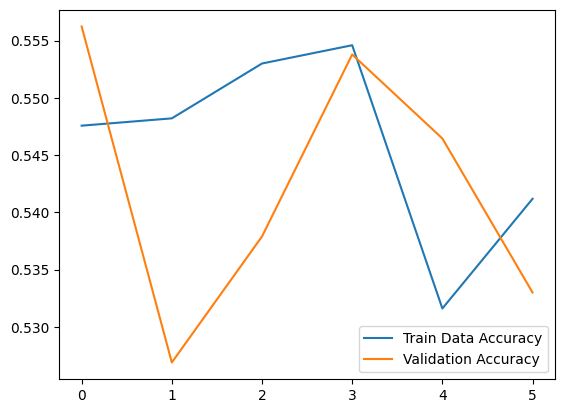

In [14]:
plt.plot(history.history['accuracy'], label = 'Train Data Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_images)
print(f'Test accuracy: {test_accuracy}')

413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3083 - loss: 0.7902
Test accuracy: 0.5399515628814697


In [16]:
model.save('transfer_resnet.keras')

In [17]:
y_scores = model.predict(test_images)
y_scores

413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step


array([[0.34558314],
       [0.60025597],
       [0.60025597],
       [0.34558314],
       [0.34558314],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.34558314],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.34558314],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.60025597],
       [0.600

In [18]:
predictions = (model.predict(test_images) > 0.43).astype(int).flatten()
print(predictions)

413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
[0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1]


In [19]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import seaborn as sns

In [20]:
CLASS_NAMES = list(train_images.class_indices.keys())
predictions = (model.predict(test_images) > 0.49374890327453613).astype(int).flatten()
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions).numpy()
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Test Accuracy: 53.995%


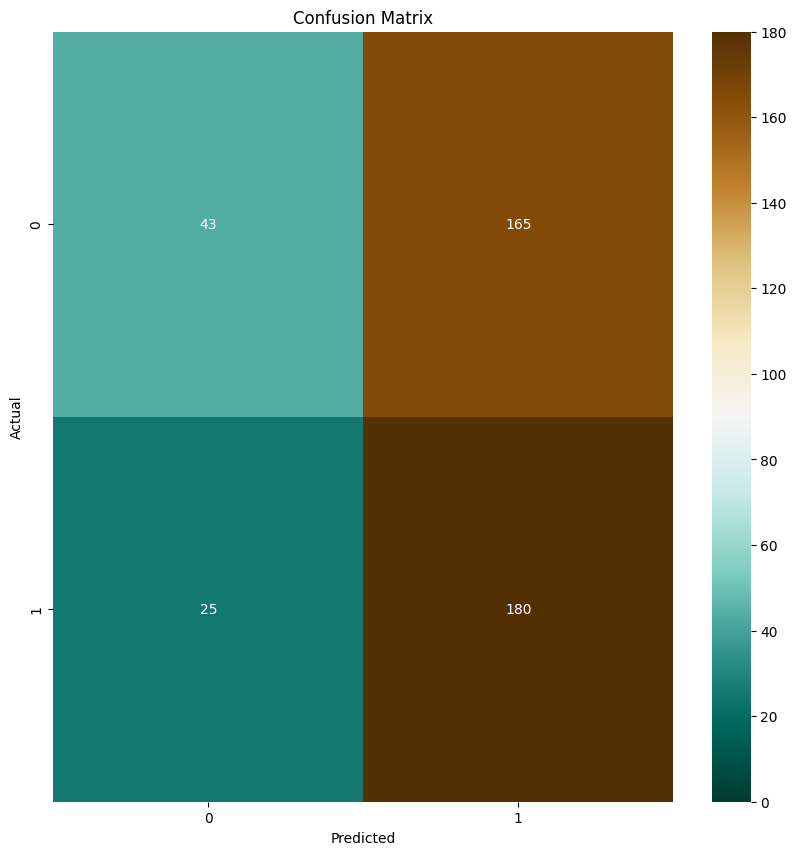

In [21]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True,fmt='d', vmin=0, cmap='BrBG_r', cbar=True)
plt.xticks(ticks= np.arange(2) + 0.5,)
plt.yticks(ticks= np.arange(2) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = test_images.classes
y_pred = predictions

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.52
Recall: 0.88
F1 Score: 0.65


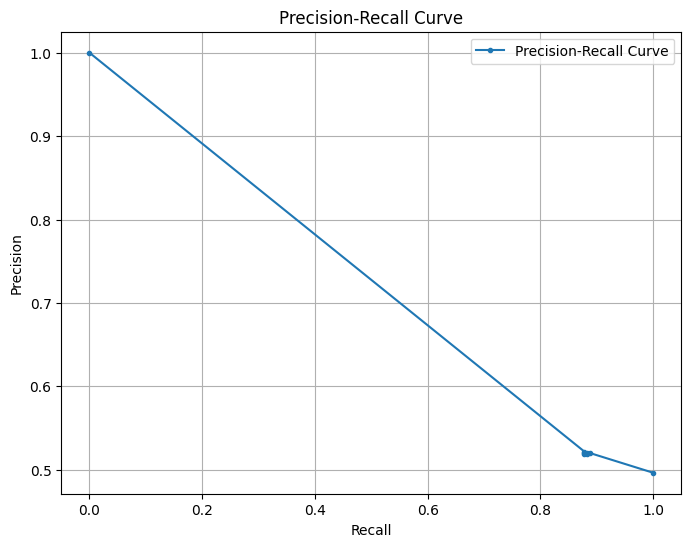

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

from sklearn.metrics import f1_score
import numpy as np

# Compute F1-score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# Find the threshold that gives the maximum F1-score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold (Max F1): {best_threshold}")


Best Threshold (Max F1): 0.34558314085006714


In [25]:
desired_precision = 0.9  # Set your desired precision
threshold = thresholds[np.argmax(precision[:-1] >= desired_precision)]
print(f"Threshold for Precision >= {desired_precision}: {threshold}")


Threshold for Precision >= 0.9: 0.34558314085006714


In [26]:
desired_recall = 0.9  # Set your desired recall
threshold = thresholds[np.argmax(recall[:-1] >= desired_recall)]
print(f"Threshold for Recall >= {desired_recall}: {threshold}")


Threshold for Recall >= 0.9: 0.34558314085006714
